# Combining Models

Now we might want to combine different models together. For example, we might want to fit a transit simultaneously with its systematics (polynomials in time, x, y, background etc.). This is very similar to the Transit and Polynomial tutorials, so if you haven't looked at those tutorials I recommend you do before this one!

In [1]:
# import chromatic_fitting of course!
from chromatic_fitting import *

# import any prior distributions we want to use for our parameters - I've chosen Normal and Uniform from pymc3
# and QuadLimbDark and ImpactParameter from exoplanet
from pymc3 import Normal, Uniform
from exoplanet import QuadLimbDark, ImpactParameter

# import astropy table just for this tutorial (pandas dataframes don't show up nicely on the docs pages!)
from astropy.table import Table

plt.matplotlib.style.use('default')

Running chromatic_fitting v0.11.0!

This program is running on:
Python v3.9.12 (main, Jun  1 2022, 06:34:44) 
[Clang 12.0.0 ]
numpy v1.22.1
chromatic v0.4.5
pymc3 v3.11.5
pymc3_ext v0.1.1
exoplanet v0.5.2


Generate some simulated data. This time we will use the handy `.inject_systematics()` and `.inject_noise()` functions in `chromatic`

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

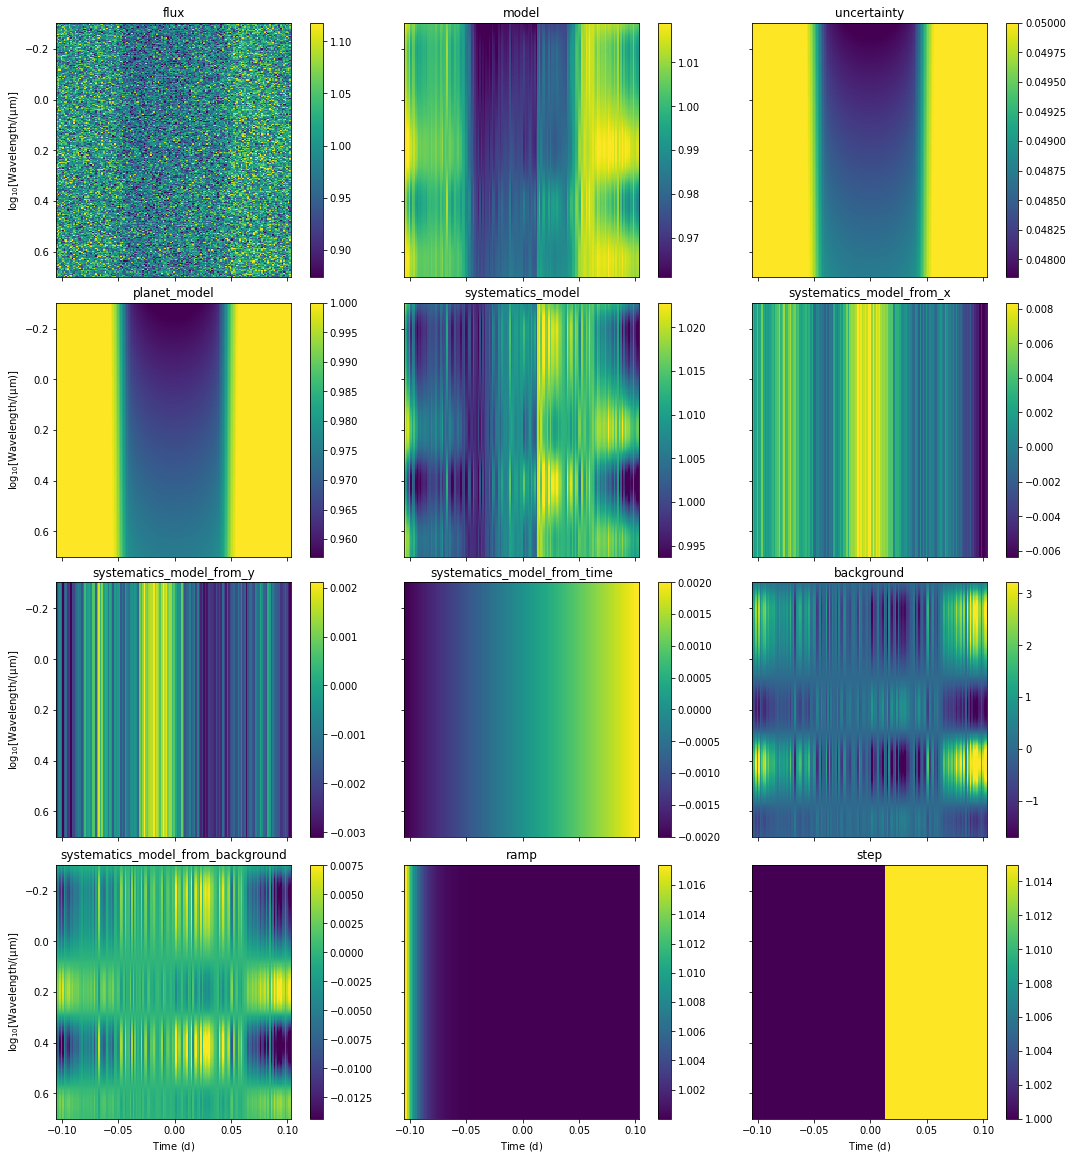

In [2]:
# create a basic simulated data set
s = SimulatedRainbow()
# inject a transit and noise as well as systematics in x, y, background and time.
s = s.inject_transit(planet_radius=np.linspace(0.2, 0.15, s.nwave)).inject_noise(signal_to_noise=20).inject_systematics(amplitude=0.005)

ramp = np.array([np.ones(s.ntime)] * s.nwave)
A = 0.02
decay_time = 0.01
C = 1
ramp = A * np.exp(-(s.time.to_value('d')-s.time[0].to_value('d'))/decay_time) + C
s.flux = s.flux * ramp
s.fluxlike['model'] = s.fluxlike['model'] * ramp
s.fluxlike['systematics_model'] = s.fluxlike['systematics_model']*ramp
s.fluxlike['ramp'] = np.array([ramp]*s.nwave)

step = np.array([np.ones(s.ntime)] * s.nwave)
step[:,85:] *= 1.015
s.flux = s.flux * step
s.fluxlike['model'] = s.fluxlike['model']*step
s.fluxlike['systematics_model'] = s.fluxlike['systematics_model']*step
s.fluxlike['step'] = step

# show all the Rainbow.fluxlike quantities:
s.imshow_quantities();
# finally, we will bin our lightcurves to make this tutorial run faster!
nwave = 3
sb = s.bin(nwavelengths=int(s.nwave/nwave), dt=5 * u.minute)

<AxesSubplot:xlabel='Time ($\\mathrm{d}$)', ylabel='log$_{10}$[Wavelength/($\\mathrm{\\mu m}$)]'>

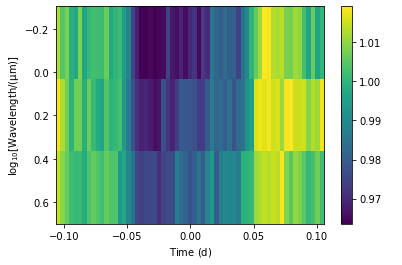

In [3]:
sb.imshow()

  0%|          | 0/150 [00:00<?, ?it/s]

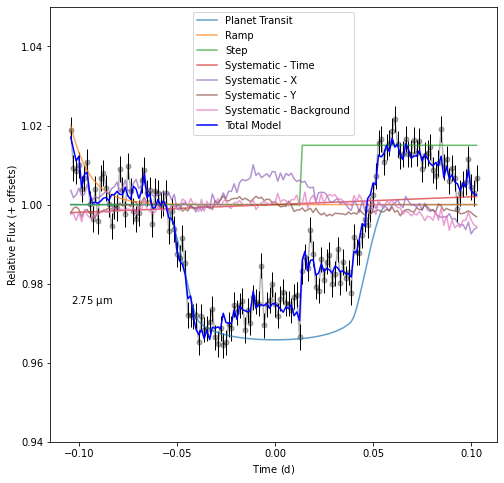

In [4]:
fig,ax = plt.subplots(figsize=(8,8))
sb2 = s.bin(nwavelengths=s.nwave)#, dt=4 * u.minute)
# sb2=s
sb2.plot_lightcurves(ax=ax,cmap='gray', plotkw={'alpha':0.3})
plt.ylim(0.94,1.05)
plt.plot(sb2.time, sb2.fluxlike['planet_model'][0], label='Planet Transit', alpha=0.7)
plt.plot(sb2.time, sb2.fluxlike['ramp'][0], label='Ramp', alpha=0.7)
plt.plot(sb2.time, sb2.fluxlike['step'][0], label='Step', alpha=0.7)
plt.plot(sb2.time, 1+sb2.fluxlike['systematics_model_from_time'][0], label='Systematic - Time', alpha=0.7)
plt.plot(sb2.time, 1+sb2.fluxlike['systematics_model_from_x'][0], label='Systematic - X', alpha=0.7)
plt.plot(sb2.time, 1+sb2.fluxlike['systematics_model_from_y'][0], label='Systematic - Y', alpha=0.7)
plt.plot(sb2.time, 1+sb2.fluxlike['systematics_model_from_background'][0], label='Systematic - Background', alpha=0.7)
plt.plot(sb2.time, sb2.fluxlike['planet_model'][0] * \
         (sb2.fluxlike['ramp'][0] + sb2.fluxlike['systematics_model_from_time'][0] + sb2.fluxlike['systematics_model_from_x'][0] + sb2.fluxlike['systematics_model_from_y'][0] + sb2.fluxlike['systematics_model_from_background'][0]) * \
         sb2.fluxlike['step'][0], label='Total Model', c='blue')
# plt.plot(sb2.time, sb2.fluxlike['model'][0], label='Total Model')
# plt.plot(sb2.time)
plt.legend();

In [5]:
sb2.fluxlike.keys()
# s.flu/xlike.keys()
# np.shape(ramp)

dict_keys(['flux', 'model', 'uncertainty', 'planet_model', 'systematics_model', 'systematics_model_from_x', 'systematics_model_from_y', 'systematics_model_from_time', 'background', 'systematics_model_from_background', 'ramp', 'step'])

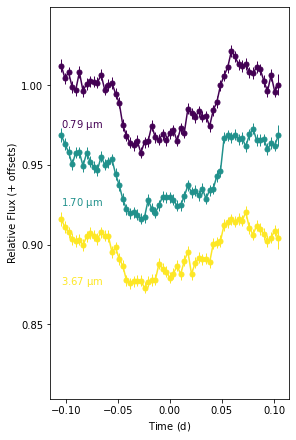

In [6]:
sb.plot_lightcurves();

Set up the transit and polynomial models. This is where we can set the distributions for every parameter, the names of the models, the degree of the polynomials, the variables we want to relate the polynomials to, etc. Here we decided to just model linear polynomials (with degree=1) for each systematic variable: 

In [7]:
# set up transit model:
t = TransitModel()
t.setup_parameters(
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.1, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=WavelikeFitted(Uniform,testval=[0.05,0.35],shape=2),
                    baseline = WavelikeFitted(Normal, mu=1.0, sigma=0.1)
                )

# set up time polynomial model:
b = PolynomialModel(degree=1, name='stime')
b.setup_parameters(
    p_0 = 1.0,
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up x polynomial model:
b_x = PolynomialModel(degree=1, independant_variable="x", name='sx')
b_x.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up y polynomial model:
b_y = PolynomialModel(degree=1, independant_variable="y", name='sy')
b_y.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up bkg polynomial model:
b_bkg = PolynomialModel(degree=1, independant_variable="background", name='sbkg')
b_bkg.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# add ramp model:
ramp = ExponentialModel(t0=s.time[0])
ramp.setup_parameters(
    A = Fitted(Uniform,testval=0.01,upper=0.05,lower=-0.05),
    decay_time = Fitted(Uniform,testval=0.001,upper=0.01,lower=0),
    baseline = 0
)

# add step model:
step = StepModel()
step.setup_parameters(
    df=Fitted(Uniform, lower=0.0, upper=0.03),
    f0=1,
    t0=Fitted(Uniform, lower=0.0, upper=0.03)
)

We can combine the models by using the standard arithmetic operators: +, -, * and /. In this case I will multiply the transit model by the sum of all the systematic polynomials. *Note: we have to be careful here not to have multiple different variables that all describe some constant offset.* For example, in the transit model we have the 'baseline' parameter that determines the out-of-transit constant flux. But in the polynomials we can also fit for the 0th order flux, 'p_0'. We should be careful not to fit for both! (By default 'p_0' will be set to 0.0 in the models where we don't define it.)

In [8]:
cmod = t * step * (b + b_x + b_y + b_bkg + ramp)
cmod

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:208: UserWarning: transit in the parameter name: transit_stellar_radius. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:208: UserWarning: step in the parameter name: step_df. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:208: UserWarning: stime in the parameter name: stime_p_0. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:208: UserWarning: sx in the parameter nam

<chromatic combined model 'combined' 🌈, models: <chromatic polynomial model 'stime' 🌈> * <chromatic polynomial model 'sx' 🌈> + <chromatic polynomial model 'sy' 🌈> + <chromatic polynomial model 'sbkg' 🌈> + <chromatic exponential model 'exponential' 🌈> + <chromatic transit model 'transit' 🌈> * <chromatic step model 'step' 🌈>

The individual models will be stored in a dictionary under `.chromatic_models`:

In [9]:
cmod._chromatic_models

{'stime': <chromatic polynomial model 'stime' 🌈>,
 'sx': <chromatic polynomial model 'sx' 🌈>,
 'sy': <chromatic polynomial model 'sy' 🌈>,
 'sbkg': <chromatic polynomial model 'sbkg' 🌈>,
 'exponential': <chromatic exponential model 'exponential' 🌈>,
 'transit': <chromatic transit model 'transit' 🌈>,
 'step': <chromatic step model 'step' 🌈>}

Let's see what parameters we have in our models:

In [10]:
cmod.summarize_parameters()

A CombinedModel itself does not have any parameters, however each of its constituent models do:

stime_p_0 =
  <🧮 Fixed | 1.0 🧮>

stime_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='stime_p_1') 🧮>

sx_p_0 =
  <🧮 Fixed | 0.0 🧮>

sx_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sx_p_1') 🧮>

sy_p_0 =
  <🧮 Fixed | 0.0 🧮>

sy_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sy_p_1') 🧮>

sbkg_p_0 =
  <🧮 Fixed | 0.0 🧮>

sbkg_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sbkg_p_1') 🧮>

exponential_A =
  <🧮 Fitted Uniform(testval=0.01, upper=0.05, lower=-0.05, name='exponential_A') 🧮>

exponential_decay_time =
  <🧮 Fitted Uniform(testval=0.001, upper=0.01, lower=0, name='exponential_decay_time') 🧮>

exponential_baseline =
  <🧮 Fixed | 0 🧮>

transit_stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_mass') 🧮>

transit_radius_rati

Then we just attach the Rainbow data to the model and run `.setup_lightcurves()` and `.setup_likelihood()` as in the previous tutorials:

In [11]:
# attach the data to our model
cmod.attach_data(sb)

# If we don't want to fit everything simultaneously we can change the optimization method (the options 
# are "separate" or "white_light"). This has to be set BEFORE running .setup_lightcurves!
cmod.choose_optimization_method('separate')

# The 'store_models' keyword can be useful later to speed up debugging/plotting, but it can slow 
# down/break fitting for large numbers of wavelengths
cmod.setup_lightcurves(normalize=False) # (store_models=True)

# Finally use the observed data to fit the model (assuming Gaussian errors!)
cmod.setup_likelihood()

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:208: UserWarning: stime in the parameter name: stime_p_0. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:208: UserWarning: sx in the parameter name: sx_p_0. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:208: UserWarning: sy in the parameter name: sy_p_0. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:208: UserWarning: sbkg in the parameter name: sbkg_p_0. Please av

In [12]:
cmod._chromatic_models

{'stime': <chromatic polynomial model 'stime' 🌈>,
 'sx': <chromatic polynomial model 'sx' 🌈>,
 'sy': <chromatic polynomial model 'sy' 🌈>,
 'sbkg': <chromatic polynomial model 'sbkg' 🌈>,
 'exponential': <chromatic exponential model 'exponential' 🌈>,
 'transit': <chromatic transit model 'transit' 🌈>,
 'step': <chromatic step model 'step' 🌈>}

If we look at our `PyMC3` model we can see that it has a lot of parameters (the combination of all our models) to optimize! If we've chosen the separate wavelength fitting method (`.choose_optimization_method("separate")`) then `._pymc3_model` will return a list of PyMC3 models (one for each wavelength).

In [13]:
cmod._pymc3_model

We've got our polynomial parameters (`stime_p_1, sx_p_1, sy_p_1, sbkg_p_1`), our transit parameters that are wavelength-independant in this case (`epoch, impact_parameter, stellar_radius, stellar_mass, a_R*, limb_darkening`) and the wavelength-dependant parameters we've defined to be `radius_ratio_w{N}` only. The `wavelength_{N}_data` parameter just represents the fit of the data to the model at each wavelength (which we've defined to be a Normal distribution). If we've decided to `store_models` then we will also see a bunch of models!

But what do the actual light curves look like?

The summarize step has not been run yet. To include the 'best-fit' model please run {self}.sample() and {self}.summarize() before calling this step!


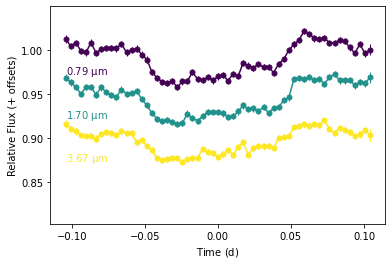

In [14]:
# plot_lightcurves(cmod)
cmod.plot_lightcurves()

We can still see the transit for each wavelength, but it's clear that the systematics would affect any derivation of the transit parameters if we didn't model for these systematics! 

## PyMC3 Sampling

Now we can run the NUTS sampling for our light curves (first by optimizing our initial values)

  0%|                                                                                | 0/3 [00:00<?, ?it/s]optimizing logp for variables: [step_t0, step_df, transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, exponential_decay_time, exponential_A, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Desired error not necessarily achieved due to precision loss.
logp: -536.4445140497554 -> 265.2599337098253
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:568: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 33%|████████████████████████                                                | 1/3 [00:14<00:29, 14.61s/it]optimizing logp for variables: [step_t0, step_df, transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, exponential_decay_time, exponential_A, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -286.7339584959331 -> 254.27504614630286


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:568: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 67%|████████████████████████████████████████████████                        | 2/3 [00:18<00:08,  8.13s/it]optimizing logp for variables: [step_t0, step_df, transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, exponential_decay_time, exponential_A, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -54.263853808162935 -> 263.09255128574887


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:568: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:21<00:00,  7.28s/it]


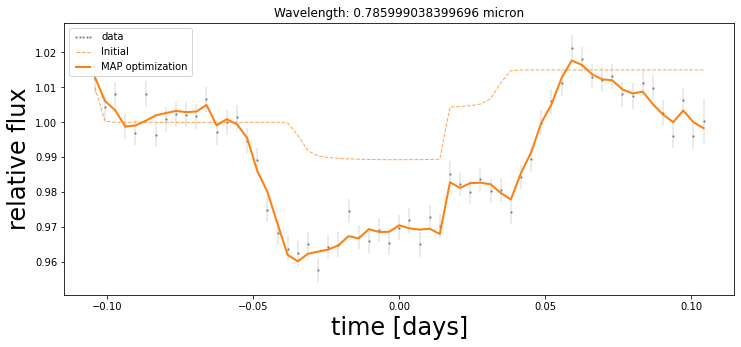

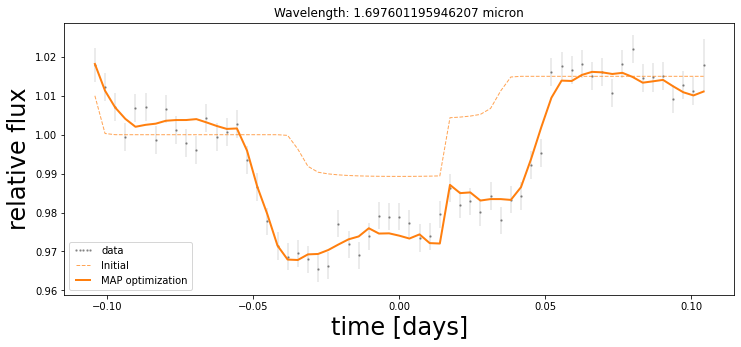

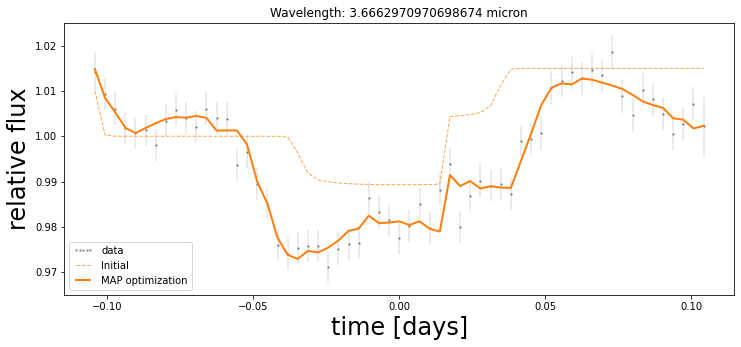

In [15]:
# optimize for initial values!
opt = cmod.optimize(plot=True)

In [16]:
# put those initial values into the sampling and define the number of tuning and draw steps, 
# as well as the number of chains. NOTE: if you do separate wavelength fitting then the number of steps 
# is per wavelengths, not divided between the wavelengths!
cmod.sample(use_optimized_start_point=True, tune=2000, draws=2000, cores=4, chains=4, return_inferencedata=False)

  0%|                                                                                | 0/3 [00:00<?, ?it/s]

Sampling model using the <function sample at 0x28d032550> method
Using MAP-optimized start point...


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [step_t0, step_df, transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, exponential_decay_time, exponential_A, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/Users/camu5866/opt/anaco

                                  mean        sd   hdi_16%   hdi_84%  \
stime_p_1[0]                 -0.000042  0.010063 -0.008988  0.010780   
sx_p_1[0]                    -0.004960  0.001261 -0.006099 -0.003618   
sy_p_1[0]                    -0.000399  0.001500 -0.001957  0.000999   
sbkg_p_1[0]                  -0.004540  0.001212 -0.005798 -0.003414   
transit_radius_ratio[0]       0.195092  0.004824  0.190157  0.199777   
transit_baseline[0]           0.999645  0.001991  0.997767  1.001682   
exponential_A[0]              0.014908  0.004073  0.011383  0.019474   
exponential_decay_time[0]     0.007115  0.001994  0.006301  0.009980   
transit_epoch[0]              0.001246  0.000665  0.000587  0.001887   
transit_impact_parameter[0]   0.096982  0.068376  0.000045  0.124052   
transit_stellar_radius[0]     1.182740  0.013581  1.178199  1.199998   
transit_stellar_mass[0]       0.837078  0.029647  0.800008  0.845888   
transit_limb_darkening[0, 0]  0.108536  0.088747  0.000019  0.13

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [step_t0, step_df, transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, exponential_decay_time, exponential_A, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/Users/camu5866/opt/anaco

                                  mean        sd   hdi_16%   hdi_84%  \
stime_p_1[0]                  0.000136  0.010185 -0.009195  0.010996   
sx_p_1[0]                    -0.003595  0.001093 -0.004639 -0.002439   
sy_p_1[0]                    -0.001459  0.001617 -0.003055  0.000157   
sbkg_p_1[0]                  -0.009465  0.007624 -0.016569 -0.001347   
transit_radius_ratio[0]       0.173709  0.004332  0.169574  0.178305   
transit_baseline[0]           0.998912  0.001570  0.997437  1.000596   
exponential_A[0]              0.016778  0.004178  0.012455  0.020565   
exponential_decay_time[0]     0.006272  0.002124  0.004070  0.008688   
transit_epoch[0]              0.000206  0.000728 -0.000517  0.000918   
transit_impact_parameter[0]   0.099450  0.069541  0.000115  0.128005   
transit_stellar_radius[0]     1.180955  0.014411  1.176030  1.199994   
transit_stellar_mass[0]       0.842234  0.032798  0.800071  0.852468   
transit_limb_darkening[0, 0]  0.070023  0.061947  0.000030  0.08

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [step_t0, step_df, transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, exponential_decay_time, exponential_A, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3

                                  mean        sd   hdi_16%   hdi_84%  \
stime_p_1[0]                  0.000063  0.009970 -0.009990  0.010201   
sx_p_1[0]                    -0.005266  0.001382 -0.006572 -0.003849   
sy_p_1[0]                    -0.001672  0.001577 -0.003127 -0.000095   
sbkg_p_1[0]                  -0.001189  0.001982 -0.003182  0.000767   
transit_radius_ratio[0]       0.154591  0.006247  0.148245  0.160443   
transit_baseline[0]           0.998391  0.002098  0.996372  1.000518   
exponential_A[0]              0.014589  0.004073  0.010658  0.018653   
exponential_decay_time[0]     0.006453  0.002129  0.005052  0.009544   
transit_epoch[0]             -0.000666  0.001136 -0.001755  0.000470   
transit_impact_parameter[0]   0.134186  0.095264  0.000592  0.170754   
transit_stellar_radius[0]     1.176981  0.020484  1.172291  1.199991   
transit_stellar_mass[0]       0.853950  0.048886  0.800075  0.864122   
transit_limb_darkening[0, 0]  0.299448  0.197686  0.008138  0.38

100%|███████████████████████████████████████████████████████████████████████| 3/3 [48:08<00:00, 962.93s/it]


At this stage the sampler may print out some warnings that we don't have enough tuning steps! We can then see the results of our sampling by running `.summarize()`

In [18]:
# print out a nice summary table (or list of tables) of our results!
cmod.summary

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
stime_p_1[0],-0.000042,0.010063,-0.008988,0.010780,0.000181,0.000147,3100.995544,3207.485842,1.001219
sx_p_1[0],-0.004960,0.001261,-0.006099,-0.003618,0.000023,0.000017,3007.004835,3292.404751,1.001618
sy_p_1[0],-0.000399,0.001500,-0.001957,0.000999,0.000027,0.000019,3144.849611,3714.561883,1.001270
sbkg_p_1[0],-0.004540,0.001212,-0.005798,-0.003414,0.000023,0.000016,2898.036628,3269.559273,1.000559
transit_radius_ratio[0],0.195092,0.004824,0.190157,0.199777,0.000089,0.000063,2944.805864,3692.036453,1.000699
transit_baseline[0],0.999645,0.001991,0.997767,1.001682,0.000037,0.000026,2975.551940,2951.389386,1.001007
exponential_A[0],0.014908,0.004073,0.011383,0.019474,0.000076,0.000054,2870.839428,3396.169602,1.000554
exponential_decay_time[0],0.007115,0.001994,0.006301,0.009980,0.000036,0.000025,2740.810369,2677.892703,1.001250
transit_epoch[0],0.001246,0.000665,0.000587,0.001887,0.000012,0.000008,3349.649103,3700.842492,1.000534
transit_impact_parameter[0],0.096982,0.068376,0.000045,0.124052,0.001438,0.001017,1923.376876,1517.878357,1.002442


An important parameter to look out for here to check whether your samplings have converged is [`r_hat`](https://arviz-devs.github.io/arviz/api/generated/arviz.rhat.html#arviz.rhat). This [rank normalized R-hat diagnostic](https://arxiv.org/abs/1903.08008) tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identicalm therefore, the closer it is to 1 the better the chance that your sampling successfully converged. If you're interested in the sampling see the [`PyMC3 docs`](https://docs.pymc.io/en/v3/index.html) for much more detail!

Then we can plot the posterior distributions and check that they look sensible (**but beware** if you've chosen the "separate" optimization method then it will plot the posteriors for every wavelength!):

But what are the results?? We can easily see the results using the handy `.get_results()` function:

In [19]:
results = cmod.get_results()#uncertainty=['hdi_16%','hdi_84%'])

# results is a pandas dataframe, however, it doesn't show up properly on Git docs so I'll convert it to an
# astropy table
Table.from_pandas(results)

stime_p_0,stime_p_0_hdi_16%,stime_p_0_hdi_84%,stime_p_1,stime_p_1_hdi_16%,stime_p_1_hdi_84%,wavelength,sx_p_0,sx_p_0_hdi_16%,sx_p_0_hdi_84%,sx_p_1,sx_p_1_hdi_16%,sx_p_1_hdi_84%,sy_p_0,sy_p_0_hdi_16%,sy_p_0_hdi_84%,sy_p_1,sy_p_1_hdi_16%,sy_p_1_hdi_84%,sbkg_p_0,sbkg_p_0_hdi_16%,sbkg_p_0_hdi_84%,sbkg_p_1,sbkg_p_1_hdi_16%,sbkg_p_1_hdi_84%,exponential_A,exponential_A_hdi_16%,exponential_A_hdi_84%,exponential_baseline,exponential_baseline_hdi_16%,exponential_baseline_hdi_84%,exponential_decay_time,exponential_decay_time_hdi_16%,exponential_decay_time_hdi_84%,transit_baseline,transit_baseline_hdi_16%,transit_baseline_hdi_84%,transit_eccentricity,transit_eccentricity_hdi_16%,transit_eccentricity_hdi_84%,transit_epoch,transit_epoch_hdi_16%,transit_epoch_hdi_84%,transit_impact_parameter,transit_impact_parameter_hdi_16%,transit_impact_parameter_hdi_84%,transit_limb_darkening,transit_limb_darkening_hdi_16%,transit_limb_darkening_hdi_84%,transit_omega,transit_omega_hdi_16%,transit_omega_hdi_84%,transit_period,transit_period_hdi_16%,transit_period_hdi_84%,transit_radius_ratio,transit_radius_ratio_hdi_16%,transit_radius_ratio_hdi_84%,transit_stellar_mass,transit_stellar_mass_hdi_16%,transit_stellar_mass_hdi_84%,transit_stellar_radius,transit_stellar_radius_hdi_16%,transit_stellar_radius_hdi_84%,step_df,step_df_hdi_16%,step_df_hdi_84%,step_f0,step_f0_hdi_16%,step_f0_hdi_84%,step_t0,step_t0_hdi_16%,step_t0_hdi_84%
object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
1.0,1.0,1.0,-4.24e-05,-0.0089877,0.0107796,0.785999038399696 micron,0.0,0.0,0.0,-0.0049596,-0.0060995,-0.0036177,0.0,0.0,0.0,-0.0003993,-0.001957,0.0009991,0.0,0.0,0.0,-0.0045397,-0.0057985,-0.0034136,0.0149077,0.0113834,0.0194741,0,0,0,0.0071153,0.0063012,0.0099799,0.9996454,0.9977671,1.0016822,0.0,0.0,0.0,0.0012457,0.0005872,0.0018869,0.0969819,4.48e-05,0.1240519,"[0.1085365, 0.1756706]","[1.88e-05, 4.95e-05]","[0.1339841, 0.2158779]",0,0,0,1,1,1,0.1950921,0.1901567,0.1997775,0.8370781,0.8000077,0.8458879,1.1827397,1.1781988,1.1999985,0.0175441,0.0156652,0.0195516,1,1,1,0.0156442,0.0148813,0.0172105
1.0,1.0,1.0,0.000136,-0.0091946,0.0109957,1.697601195946207 micron,0.0,0.0,0.0,-0.0035951,-0.0046386,-0.0024386,0.0,0.0,0.0,-0.0014593,-0.0030548,0.000157,0.0,0.0,0.0,-0.0094655,-0.0165688,-0.0013466,0.0167776,0.012455,0.0205651,0,0,0,0.0062716,0.0040698,0.0086879,0.9989117,0.9974366,1.0005958,0.0,0.0,0.0,0.0002062,-0.0005173,0.0009178,0.0994503,0.0001146,0.1280054,"[0.0700231, 0.1494789]","[3.01e-05, 0.0002849]","[0.0829839, 0.1801566]",0,0,0,1,1,1,0.1737093,0.169574,0.1783046,0.8422341,0.8000707,0.8524678,1.1809552,1.1760297,1.1999939,0.0166717,0.0146738,0.0184053,1,1,1,0.0137598,0.0104178,0.0150403
1.0,1.0,1.0,6.25e-05,-0.0099899,0.0102014,3.6662970970698674 micron,0.0,0.0,0.0,-0.0052659,-0.0065719,-0.0038493,0.0,0.0,0.0,-0.0016725,-0.0031272,-9.49e-05,0.0,0.0,0.0,-0.001189,-0.0031817,0.000767,0.0145892,0.0106582,0.0186535,0,0,0,0.0064526,0.0050525,0.0095436,0.9983912,0.9963718,1.0005178,0.0,0.0,0.0,-0.0006656,-0.0017546,0.0004699,0.1341863,0.000592,0.1707539,"[0.2994483, 0.3837535]","[0.0081385, 1.4e-06]","[0.3882334, 0.497481]",0,0,0,1,1,1,0.1545914,0.1482445,0.1604433,0.8539498,0.8000753,0.8641216,1.1769807,1.1722912,1.199991,0.0148937,0.0128803,0.0169357,1,1,1,0.0121729,0.0113667,0.0138347


We can also make a transmission spectrum table using `.make_transmission_spectrum_table() `

In [20]:
cmod.models['w0']

<chromatic combined model 'combined' 🌈, models: <chromatic polynomial model 'stime' 🌈> * <chromatic polynomial model 'sx' 🌈> + <chromatic polynomial model 'sy' 🌈> + <chromatic polynomial model 'sbkg' 🌈> + <chromatic exponential model 'exponential' 🌈> + <chromatic transit model 'transit' 🌈> * <chromatic step model 'step' 🌈>

In [21]:
# this will show errors for the models that aren't transit and return a list!
transmission_spectrum = cmod.make_transmission_spectrum_table()
# transmission_spectrum = make_transmission_spectrum_table(cmod)
# transmission_spectrum
Table.from_pandas(transmission_spectrum)

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/transit.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_table[f"{name}_radius_ratio_neg_error"] = (


wavelength,transit_radius_ratio,transit_radius_ratio_neg_error,transit_radius_ratio_pos_error
object,object,object,object
0.785999038399696 micron,0.1950921,0.004935399999999979,0.004685400000000006
1.697601195946207 micron,0.1737093,0.004135300000000008,0.004595299999999997
3.6662970970698674 micron,0.1545914,0.006346899999999989,0.005851900000000021


We can also create (or call if you set `store_models=True`) the final best-fit models using the `.get_models()` function. This can take a minute if generating the models from parameters for lots of wavelengths.

In [22]:
models = cmod.get_model()
models.keys()

dict_keys(['w0', 'w1', 'w2'])

As the `.get_model()` process can take time to generate the models, we store the models for use later...

In [40]:
cmod._fit_models.keys()

dict_keys(['w0', 'w1', 'w2'])

## Plotting the final results

We have several different methods (mostly wrappers to `chromatic` functions) to plot the modelled results. I'll demonstrate several of them below:

`plot_model()` is an especially useful function for CombinedModels because it allows us to split the model into constituent models and see the relative contribution of each!

In [57]:
cmod.models['w0'].name#get_model()

'combined'

In [119]:
def plot_model(self, normalize=True, plot_data=True, wavelength=None, **kw):
    """

    Parameters
    ----------
    normalize: Boolean to normalize all models to mean~1, some models will have default mean~0 (default=True)
    plot_data: Boolean to add real data on top of model plots (default=True)
    kw: Any additional keywords to pass to plot_one_model(), e.g. wavelength, ax

    Returns
    -------

    """
    model = self.get_model()

    def plot_models_for_each_w(ax, mod, name_label, normalize):
        if normalize:
            if np.nanmedian(mod) < 0.1:
                ax.plot(self.data.time, mod + 1, label=f"{name_label}")
            else:
                ax.plot(self.data.time, mod, label=f"{name_label}")
        else:
            ax.plot(self.data.time, mod, label=f"{name_label}")

    def plot_one_model(model, normalize, wavelength, name_label=None, **kw):
        wave_num = [int(k.replace("w","")) for k in model.keys()]
        
        if wavelength is not None:
            try:
                model_one_wavelength = {}
                if type(wavelength) == int:
                    i = wavelength
                    if f"w{i}" in model.keys():
                        model_one_wavelength[f"w{i}"] = model[f"w{i}"]
                    else:
                        return
#                     else:
#                         model_one_wavelength[f"w{i}"] = model["w0"]
                else:
                    for i in wavelength:
                        if f"w{i}" in model.keys():
                            model_one_wavelength[f"w{i}"] = model[f"w{i}"]
                    if len(model_one_wavelength.values()) == 0:
                        return
                model = model_one_wavelength
            except:
                return


        if "ax" in kw:
            ax = kw["ax"]
        else:
            if len(wave_num) == 1 or wavelength is not None:
                figsize = (8, 4)
            else:
                figsize = (8, 16)

            if wavelength is not None:
                fi, ax = plt.subplots(
                    nrows=len(wave_num),
                    figsize=figsize,
                    constrained_layout=True,
                )
            else:
                # make sure ax is set up
                fi, ax = plt.subplots(
                    nrows=len(wave_num),
                    figsize=(8, 4),
                    constrained_layout=True,
                )
            if len(wave_num) == 1:
                ax = [ax]
            kw["ax"] = ax

        if name_label is None:
            name_label = self.name

        for wnum, ax_i, mod in zip(wave_num, ax, model.values()):
            if isinstance(self, CombinedModel):
                list_of_chrom_mods = list(self._chromatic_models.keys())
                list_of_chrom_mods.append("total")
                for chrom_mod in list_of_chrom_mods:
                    plot_models_for_each_w(
                        ax_i, mod[chrom_mod], chrom_mod, normalize
                    )
            else:
                plot_models_for_each_w(ax_i, mod, name_label, normalize)

            if plot_data:
                if wnum > 0 and self.data.nwave == 1:
                    flux = self.data.flux[0, :]
                    uncertainty = self.data.uncertainty[0, :]
                else:
                    flux = self.data.flux[wnum, :]
                    uncertainty = self.data.uncertainty[wnum, :]

                ax_i.plot(self.data.time, flux, "k.")
                ax_i.errorbar(
                    self.data.time,
                    flux,
                    uncertainty,
                    color="k",
                    linestyle="None",
                    capsize=2,
                )
            ax_i.set_title(f"Wavelength {wnum}")
            ax_i.set_ylabel("Relative Flux")
            ax_i.set_xlabel("Time [d]")
            ax_i.legend()

        return kw

    plot_one_model(model, normalize=normalize, wavelength=wavelength, **kw)

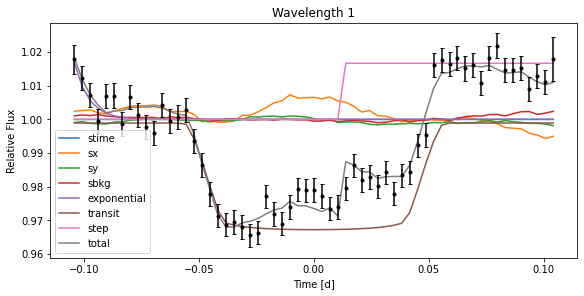

In [123]:
for name, mod in cmod.models.items():
#     print(mod.get_model())
    plot_model(mod, wavelength=[1])

We can also just choose to see a single model or wavelength:

100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 88.90it/s]


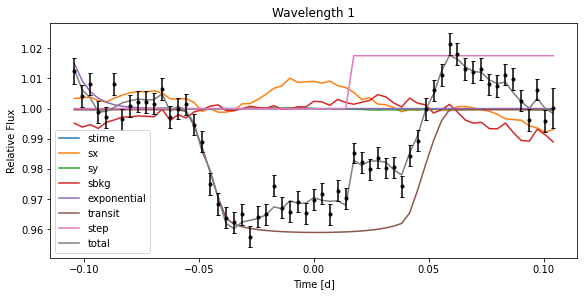

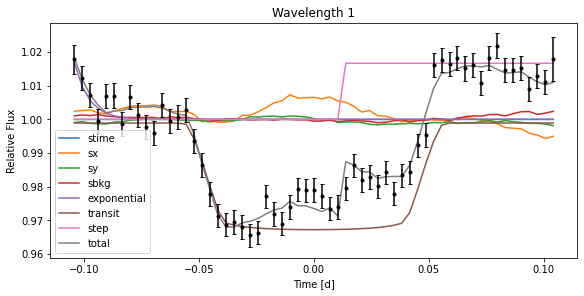

In [62]:
cmod.plot_model(wavelength=1)

100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 82.30it/s]


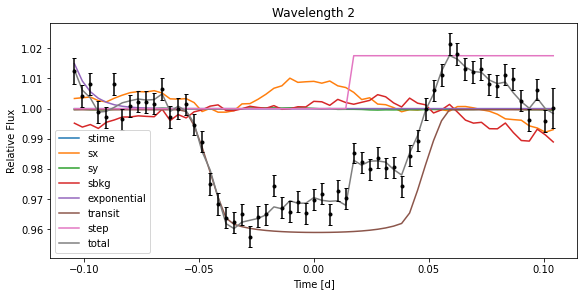

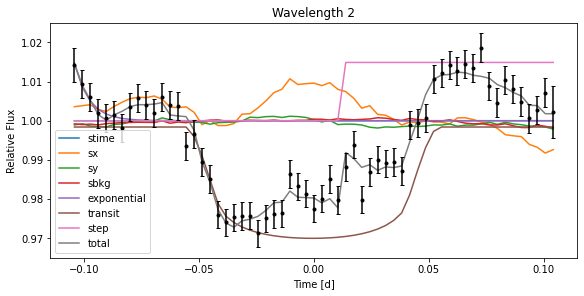

In [37]:
cmod.plot_model(wavelength=2)

`.plot_lightcurves()` will plot the same lightcurves as before but now with our models on top!

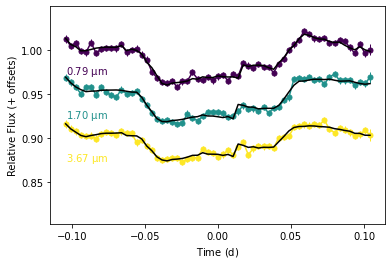

In [27]:
# plot_lightcurves(cmod)
cmod.plot_lightcurves()

No model attached to data. Running `add_model_to_rainbow` now. You can access this data later using [self].data_with_model


100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.69it/s]


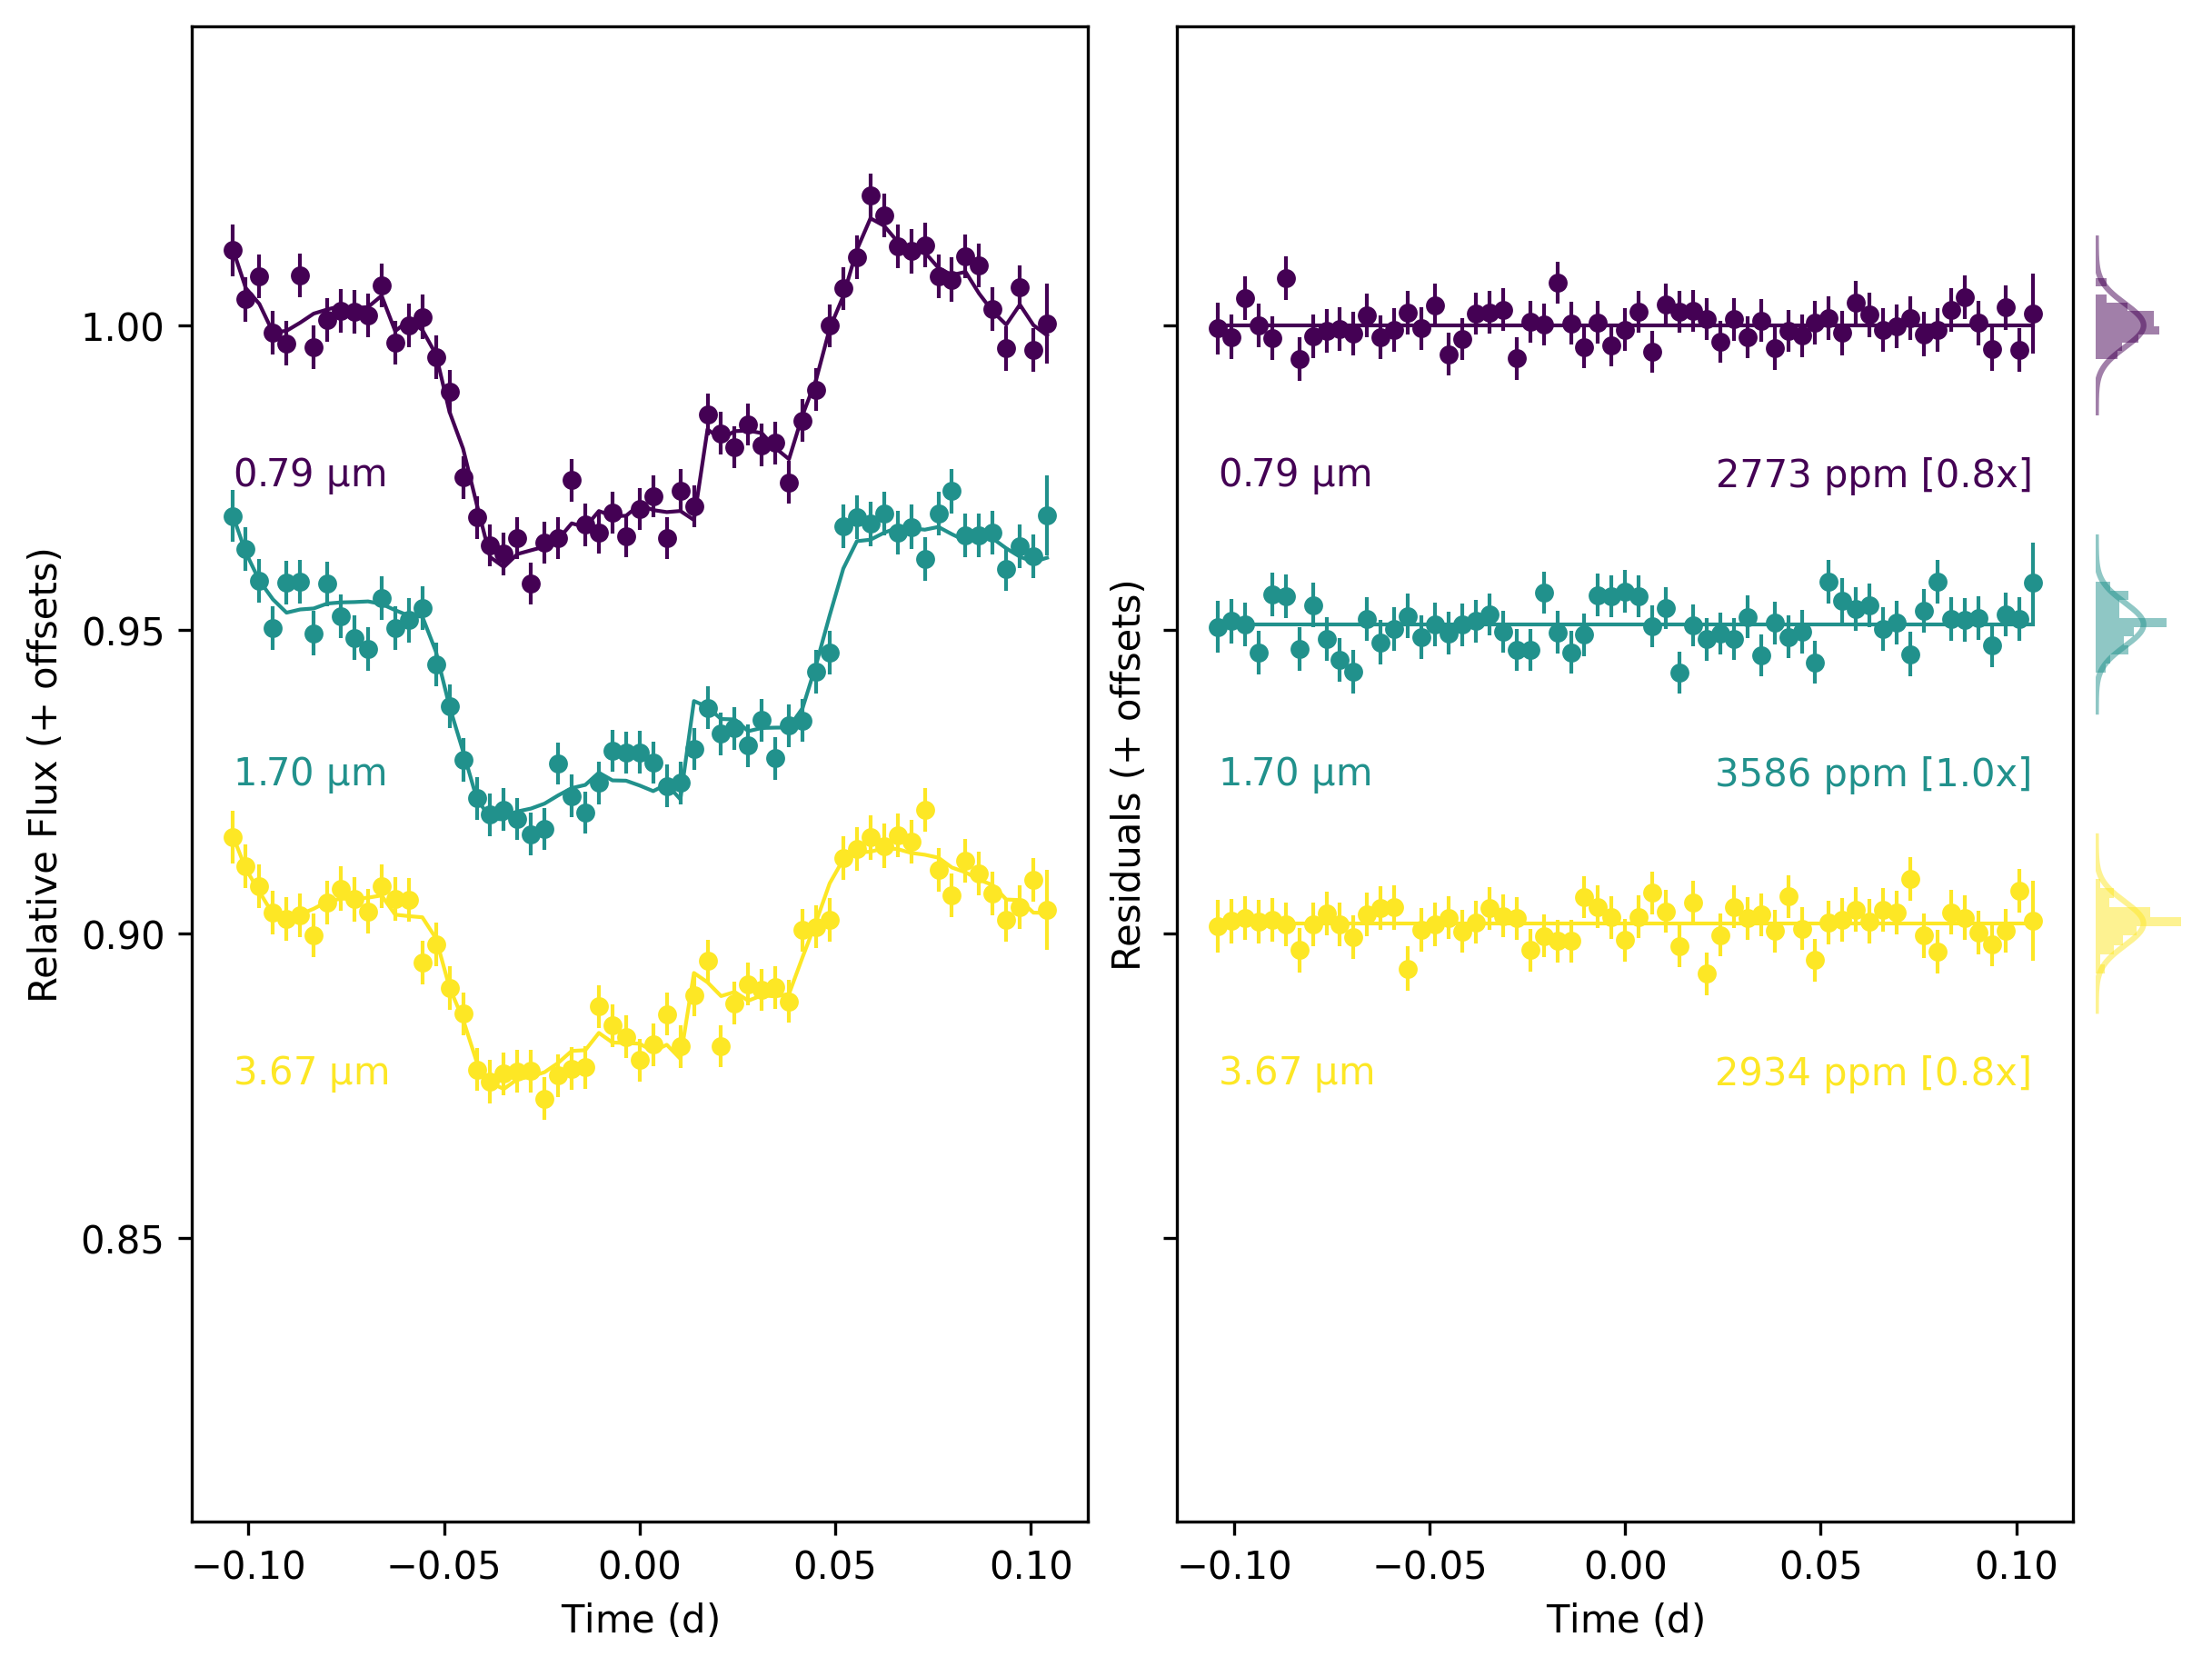

In [28]:
cmod.plot_with_model_and_residuals()

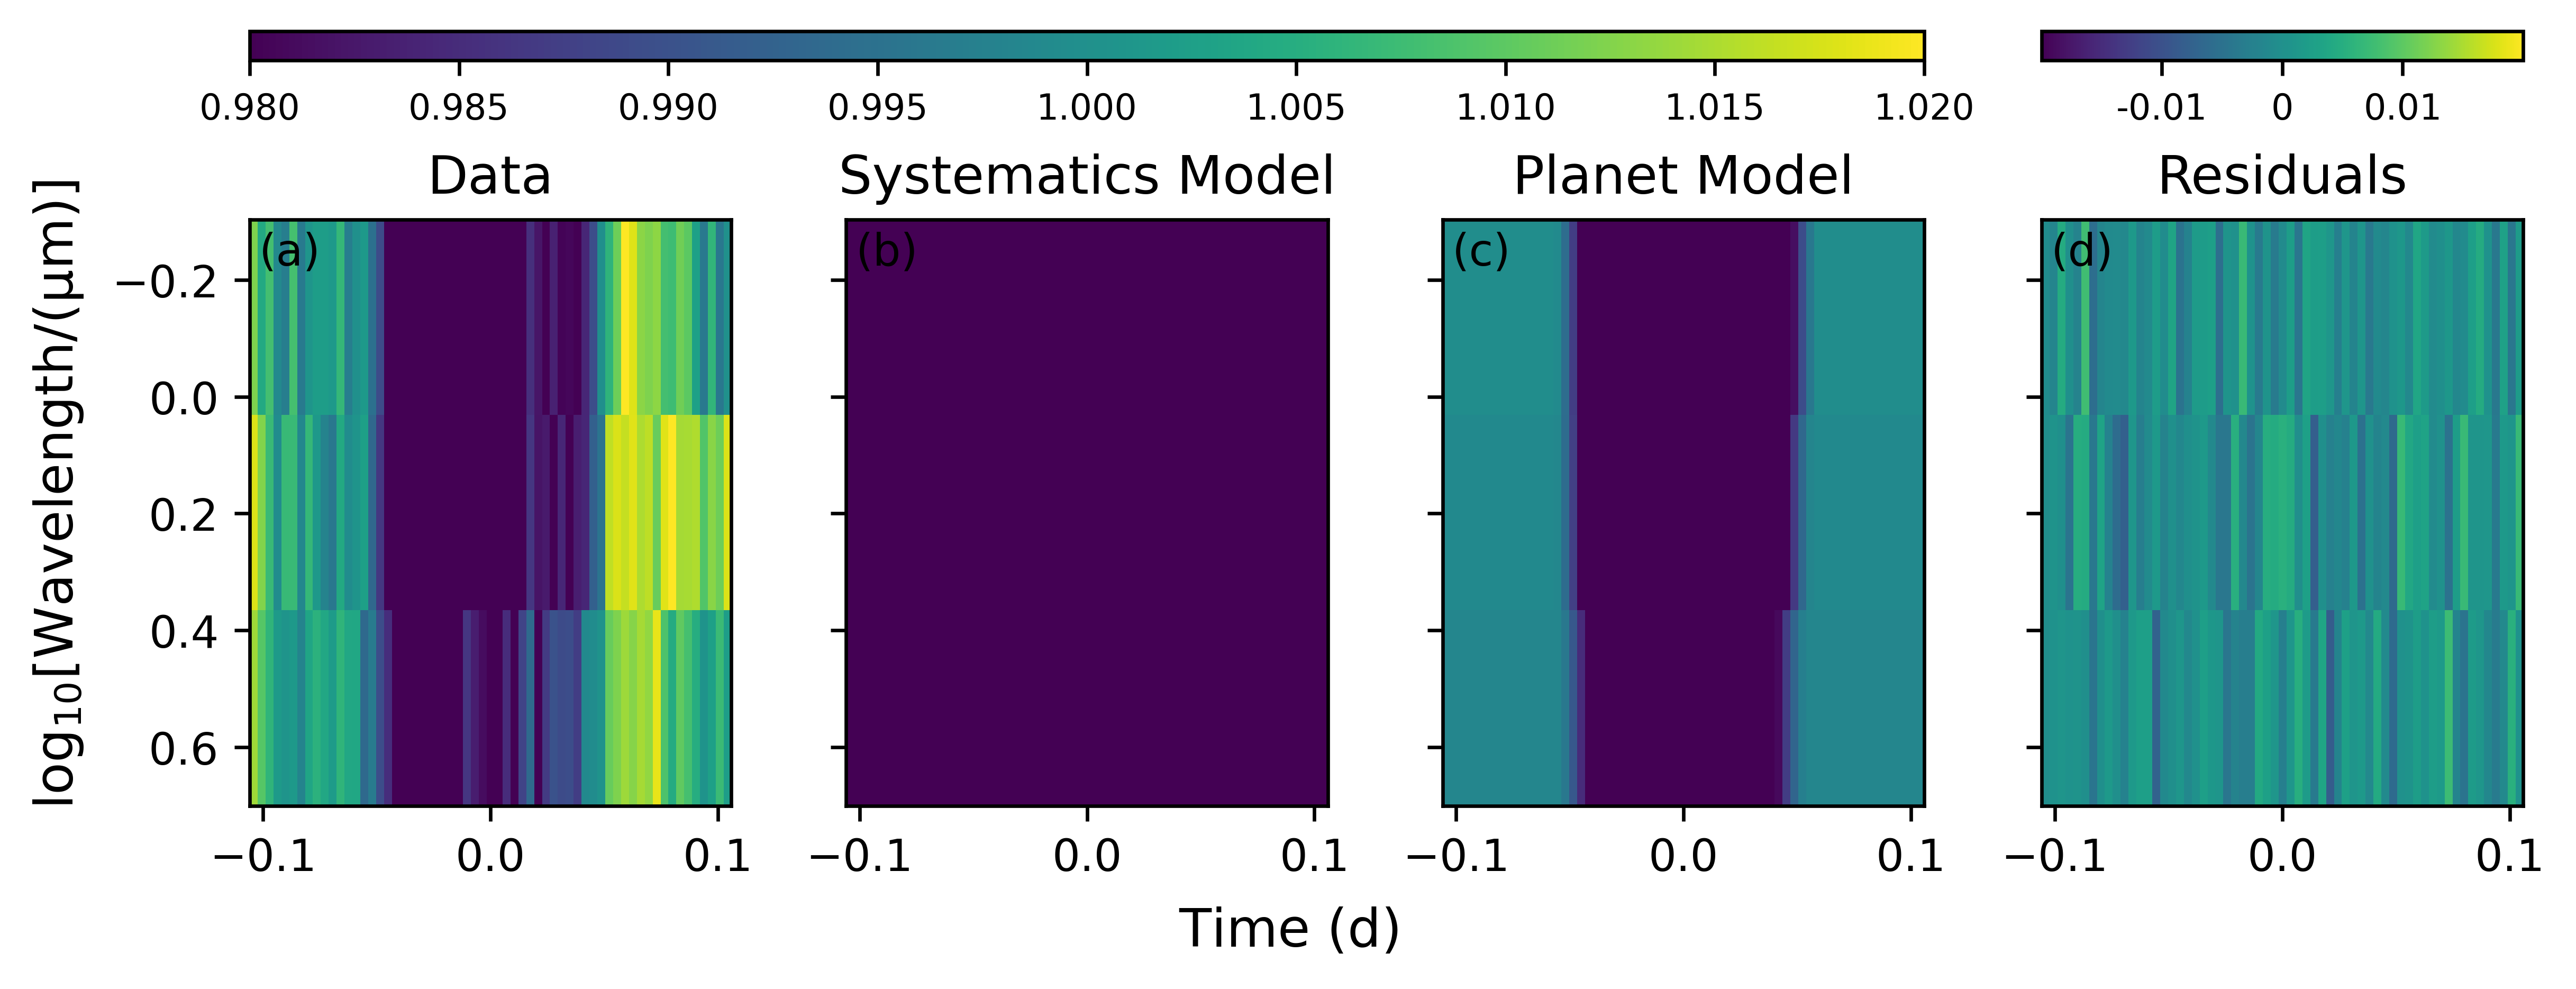

In [29]:
# plot the 3D light curves (flux as a function of time and wavelength) with the residuals
cmod.imshow_with_models()

We can even make gifs to step through each wavelength:

  0%|          | 0/3 [00:00<?, ?it/s]

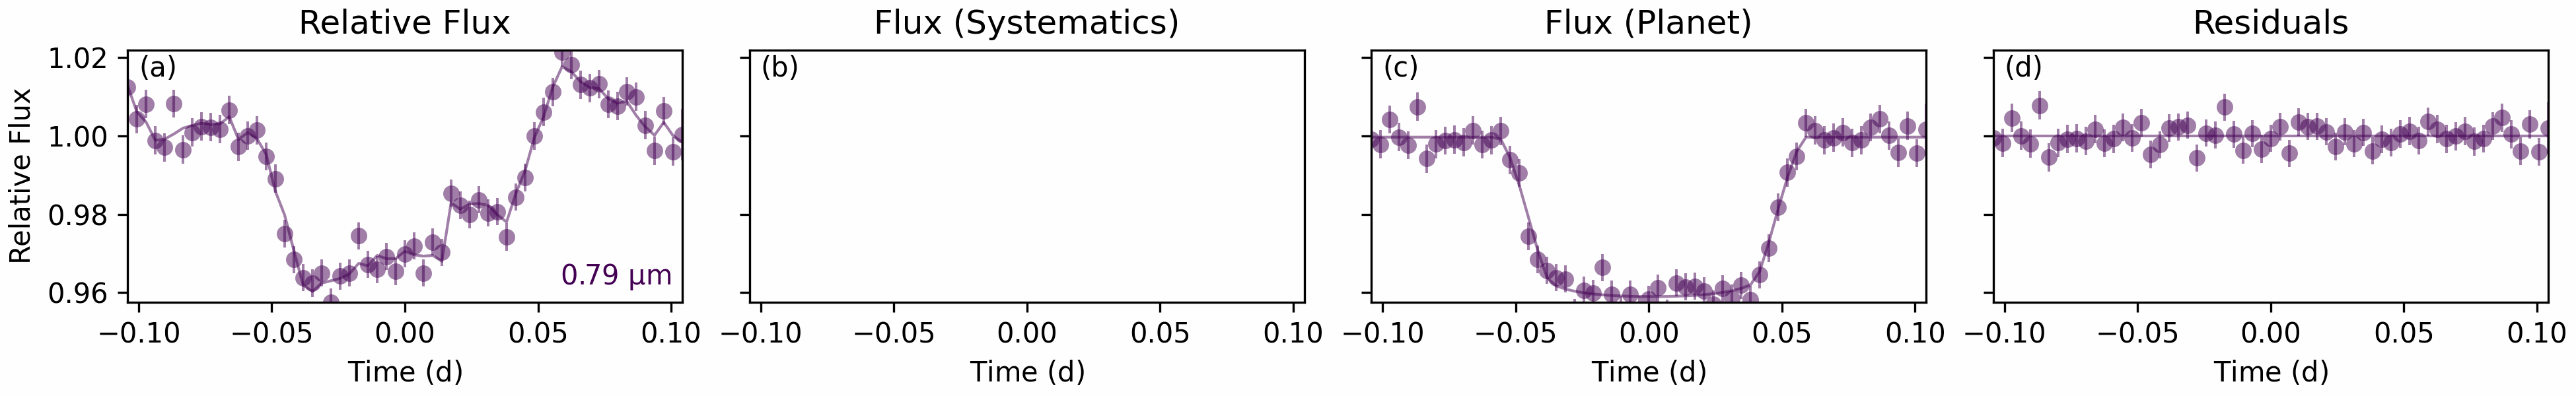

In [30]:
cmod.animate_with_models()#orientation='vertical', panelsize=(7,2))

We can plot the transmission spectrum:

In [31]:
transmission_table = cmod.make_transmission_spectrum_table()
transmission_table

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/transit.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_table[f"{name}_radius_ratio_neg_error"] = (


,wavelength,transit_radius_ratio,transit_radius_ratio_neg_error,transit_radius_ratio_pos_error
w0,0.785999038399696 micron,0.195092,0.004935,0.004685
w1,1.697601195946207 micron,0.173709,0.004135,0.004595
w2,3.6662970970698674 micron,0.154591,0.006347,0.005852


In [32]:
cmod.transmission_spectrum

,wavelength,transit_radius_ratio,transit_radius_ratio_neg_error,transit_radius_ratio_pos_error
w0,0.785999038399696 micron,0.195092,0.004935,0.004685
w1,1.697601195946207 micron,0.173709,0.004135,0.004595
w2,3.6662970970698674 micron,0.154591,0.006347,0.005852


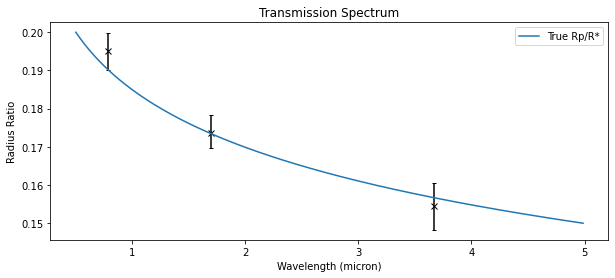

In [33]:
cmod.plot_transmission_spectrum()
plt.plot(SimulatedRainbow().wavelength, np.linspace(0.2, 0.15, SimulatedRainbow().nwave), label="True Rp/R*")
plt.legend();

And assess the quality of our fit with a chi-squared test (with `.chi_squared`):


For Entire Simultaneous Fit:
Fitted Parameters:
 stime_p_1[0], sx_p_1[0], sy_p_1[0], sbkg_p_1[0], transit_radius_ratio[0], transit_baseline[0], exponential_A[0], exponential_decay_time[0], transit_epoch[0], transit_impact_parameter[0], transit_stellar_radius[0], transit_stellar_mass[0], transit_limb_darkening[0, 0], transit_limb_darkening[0, 1], transit_a_R*[0], transit_planet_radius[0], step_df[0], step_t0[0], stime_p_1[1], sx_p_1[1], sy_p_1[1], sbkg_p_1[1], transit_radius_ratio[1], transit_baseline[1], exponential_A[1], exponential_decay_time[1], transit_epoch[1], transit_impact_parameter[1], transit_stellar_radius[1], transit_stellar_mass[1], transit_limb_darkening[1, 0], transit_limb_darkening[1, 1], transit_a_R*[1], transit_planet_radius[1], step_df[1], step_t0[1], stime_p_1[2], sx_p_1[2], sy_p_1[2], sbkg_p_1[2], transit_radius_ratio[2], transit_baseline[2], exponential_A[2], exponential_decay_time[2], transit_epoch[2], transit_impact_parameter[2], transit_stellar_radius[2], tran

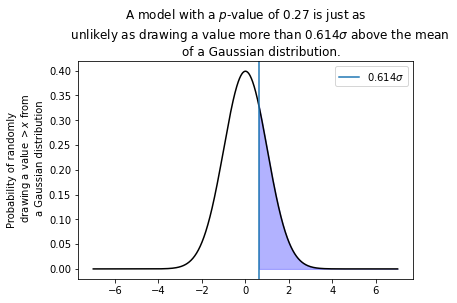

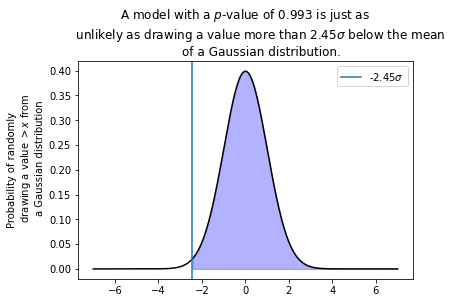

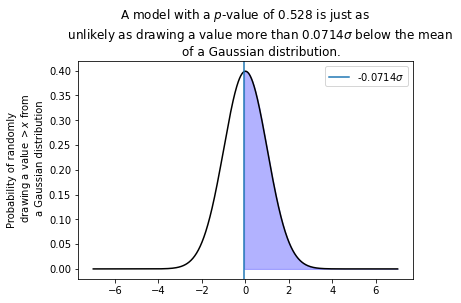

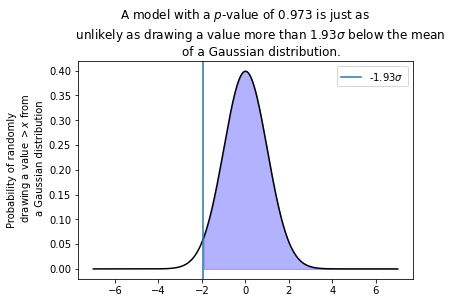

In [34]:
cmod.chi_squared(plot=True, individual_wavelengths=True)

For the Wavelength-Averaged Residuals...


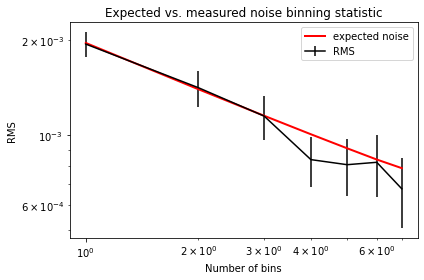

Calculated white noise: 0.0018764 

        Calculated red noise: 0.00054529 

        Calculated beta: 1.3929

For wavelength 0


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/utils.py:75: RuntimeWarning: invalid value encountered in sqrt
  base_noise = np.sqrt(final_noise**2 - root_mean_square[0] ** 2 / nbins[midbin])


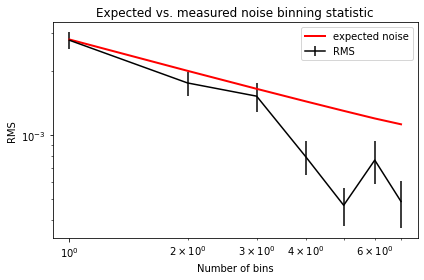

Calculated white noise: 0 

        Calculated red noise: 0 

        Calculated beta: 1

For wavelength 1


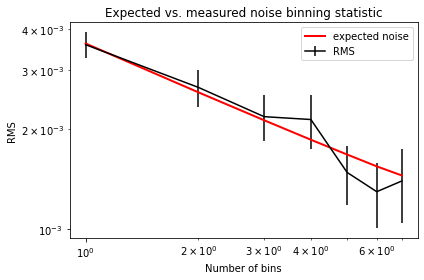

Calculated white noise: 0.0034642 

        Calculated red noise: 0.00096468 

        Calculated beta: 1.3669

For wavelength 2


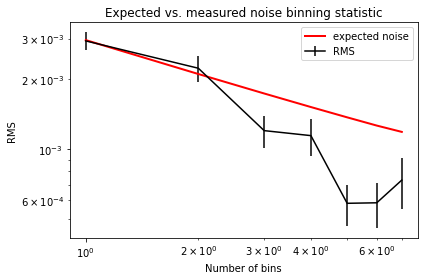

Calculated white noise: 0 

        Calculated red noise: 0 

        Calculated beta: 1


In [35]:
cmod.residual_noise_calculator(individual_wavelengths=True)